In [91]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
from sklearn.metrics import classification_report, confusion_matrix  

In [92]:
#Read in Stata datafile
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [93]:
data_raw = pd.read_csv('../Data/cns_data.csv')

In [94]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)


In [95]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [273]:
#Clinical measures
clin_df = data_raw.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                         'dimain',\
                         'diag']] #This is the final diagnosis. Keep this in here so you drop the right cases.

#Convert the date into a useful value. This just counts the days from the beginning of the dataset, which is probably
#not the best way of doing it. I suspect the month and day are relevent, but probably not the year. If seasonality
#is strong here, anyway.
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth

#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0, 'virus-bacteria':1, 'bacteremia':1,\
                            'bact meningitis' :1,'virus-other':2,'virus-malaria':0,'malaria-bacterial':3,\
                            'tb':4,'virus':2,'crypto':4, '0.0':2})

In [377]:
#What's going on with the glasgow and balntyre scores?
clin_df.glasgtot.unique()
clin_df.blanttot.unique()
#How many have a glasgow score? 427
#How many have a Blantyre score? 53. We won't use this one

array([nan,  3.,  4.,  2.,  1.,  5.,  0.])

In [364]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [365]:
#You really shouldn't use these as categorical variables - you need to turn them each into a yes/no question.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

print clin_df.dimain.unique()

[0. 1. 2. 3.]


In [413]:
#Try a decision tree classification with some of these. Will probably be pretty bad.
#You'll have to figure out how to remove the entries with NaNs
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'sbp',\
                      'conv','abdpain','vom','diar','muscle',\
                      'diag']]
X_pd = X_pd.dropna()

In [414]:
Input = X_pd.as_matrix()
Features = Input[:,0:-1].copy()
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print ncase

367


In [404]:
X = Features.copy()
y = Labels.copy()

In [405]:
'''
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("iris")
'''

'\ndot_data = tree.export_graphviz(clf, out_file=None) \ngraph = graphviz.Source(dot_data)\ngraph.render("iris")\n'

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Feature ranking:
1. feature 0 (0.135275)
2. feature 7 (0.096433)
3. feature 22 (0.095783)
4. feature 5 (0.094166)
5. feature 6 (0.091532)
6. feature 2 (0.084504)
7. feature 1 (0.050882)
8. feature 10 (0.041874)
9. feature 25 (0.030274)
10. feature 19 (0.030097)


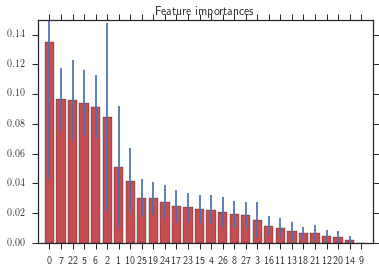

In [412]:
#You should really be doing a random forest.
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
#for full feature listing use this as the range X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [408]:
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [409]:
#Print the confusion matrix:
print confusion_matrix(y_test,y_pred)
print classification_report(y_test,y_pred)

[[35  4  8  0  0]
 [ 3  3 15  0  0]
 [ 9 10 47  0  0]
 [ 4  0  0  0  0]
 [ 0  1  2  0  0]]
             precision    recall  f1-score   support

        0.0       0.69      0.74      0.71        47
        1.0       0.17      0.14      0.15        21
        2.0       0.65      0.71      0.68        66
        3.0       0.00      0.00      0.00         4
        4.0       0.00      0.00      0.00         3

avg / total       0.56      0.60      0.58       141



In [410]:
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,50)

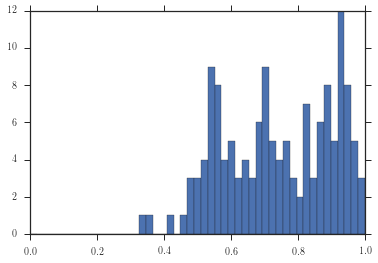

In [411]:
a,b,c = plt.hist(probmax,bins=edges)